In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from os import listdir
from os.path import isfile, join
from ast import literal_eval
import math
import copy
import itertools
from geopy import distance

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import matplotlib as mpl
from cmcrameri import cm


from greedy_hospital_tmp import add_temp_facility, greedy_tmp, wait_disagg_tmp, manual_order_tmp
from greedy_hospital import greedy, manual_order, calculate_area, create_times, get_cons_order, get_capacity_order, wait_disagg
from cons_simulation import *

/opt/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Functions

In [2]:
def wait_at_home(result, cons_time, tmp_facilities, k, travel_time = None, dist_dict = None,
                         num_crews = 1):

    #cumulative construction time
    if num_crews == 1:
        cons_cum = np.cumsum([cons_time[i] for i in result['order']])
    else:
        _, cons_cum = simulate_recovery(result['order'], num_crews, cons_time)

        # get index of unique construction time
        unique_time_idx = [0]
        for j in range(1,len(cons_cum)):
            if cons_cum[j] != cons_cum[j-1]:
                unique_time_idx.append(j)
    

    # get patients that are in the temporary facilities
    alloc = []
    if num_crews == 1:
        for i in range(len(result['allocation_time'])):
            alloc_curr = result['allocation_time'][i]
            alloc_curr = [val for key,val in alloc_curr.items() if key[1] == k and key[0] in tmp_facilities]
            alloc_curr = [item for sublist in alloc_curr for item in sublist] # flatten
            alloc.append(alloc_curr)
    else:
        for i in unique_time_idx: # only take certain time steps
            alloc_curr = result['allocation_time'][i]
            alloc_curr = [val for key,val in alloc_curr.items() if key[1] == k and key[0] in tmp_facilities]
            alloc_curr = [item for sublist in alloc_curr for item in sublist] # flatten
            alloc.append(alloc_curr)
    
    # find how many days patients in temporary facility have to be waiting at home
    leftover = []
    for i in range(1, len(alloc)):
        leftover_curr = np.array([n for n in alloc[i] if (n in alloc[i-1]) and alloc[i-1].remove(n)] + alloc[i-1])
        leftover.append(len(leftover_curr))

    if num_crews == 1:
        wait_home = np.repeat(cons_cum, leftover)
    else:
        wait_home = np.repeat(np.unique(cons_cum[1:]), leftover)
    
    # get patients that only have to wait in the facility
    # and make a time series of the waiting time every single day
    if num_crews == 1:
        cons_series = [cons_time[i] for i in result['order']] + [1] 
        wait = wait_disagg_tmp('total', result, tmp_facilities, k = k,dist_dict = dist_dict, travel_time = travel_time, mean = False)
        wait_repeat = np.repeat(wait, cons_series)
    else: 
        wait = wait_disagg_tmp('total', result, tmp_facilities, k = k,dist_dict = dist_dict, travel_time = travel_time, mean = False)
        cons_series = np.concatenate([np.diff(cons_cum[unique_time_idx]),[1]])
        wait_repeat = np.repeat(np.array(wait)[unique_time_idx], cons_series)
    
    # calculate mean waiting time of all patients
    mean_total_wait= np.zeros(len(wait_repeat))
    for i in range(len(mean_total_wait)):
        wait_facility = wait_repeat[i]/24 # convert into days
        wait_in_tmp = wait_home - i # every day wait time reduces
        wait_in_tmp_max= np.array([max(j, 0) for j in wait_in_tmp])
        wait_in_tmp_filter = wait_in_tmp_max[wait_in_tmp_max != 0] # patients no longer wait at home
        all_patients = np.concatenate([wait_facility, wait_in_tmp_filter]) # combine treated and untreated patients
        mean_total_wait[i] = np.mean(all_patients)
    
    return mean_total_wait

In [3]:
def count_untreated_prio(k, damaged_facilities, tmp_facilities, result, interval = 0.1):
    num_in_tmp = np.zeros(len(damaged_facilities)+1)
    for i in range(len(num_in_tmp)):
        alloc = result['allocation_time'][i]
        num_in_tmp[i] = sum(len(vals) for key, vals in alloc.items() if (key[0] in tmp_facilities) and (key[1] == k))*interval
    
    return num_in_tmp

In [4]:
hosp_data_mod = pd.read_csv('../Data/lima_emergency_data_mod.csv')

def map_ordering(hosp_data, ordering, damaged_facilities, func_facilities, mu, svr, filename):
    
    # damaged buildings
    x = hosp_data.loc[hosp_data['ID'].isin(damaged_facilities), 'lon'].values
    y = hosp_data.loc[hosp_data['ID'].isin(damaged_facilities), 'lat'].values
    c = [ordering.index(h) for h in hosp_data.loc[hosp_data['ID'].isin(damaged_facilities), 'ID'].values]
    s = [mu[h]*svr[h]*20 for h in hosp_data.loc[hosp_data['ID'].isin(damaged_facilities), 'ID'].values]

    geometry = [Point(xy) for xy in zip(x,y)]
    geo_df = gpd.GeoDataFrame(geometry= geometry, crs = 'epsg:4326')

    # undamaged buildings
    x_u = hosp_data.loc[hosp_data['ID'].isin(func_facilities), 'lon'].values
    y_u = hosp_data.loc[hosp_data['ID'].isin(func_facilities), 'lat'].values
    s_u = [mu[h]*svr[h]*15 for h in hosp_data.loc[hosp_data['ID'].isin(func_facilities), 'ID'].values]

    geometry = [Point(xy) for xy in zip(x_u,y_u)]
    undamaged = gpd.GeoDataFrame(geometry= geometry, crs = 'epsg:4326')
    
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # setup the plot

#     cmap = plt.cm.plasma_r  # define the colormap
    cmap = cm.lajolla
    cmaplist = [cmap(i) for i in range(cmap.N)] 

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, len(x), len(x)+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # make the scatter
    u_scat = ax.scatter(x_u,y_u, color = 'white', edgecolors = 'grey', s = s_u, alpha = 0.8) # undamaged
    scat = ax.scatter(x,y,c = c, cmap = cmap, s = s, norm = norm, alpha = 0.8, edgecolors = 'grey') # damaged

    # annotate labels
    bldg_id = hosp_data['ID'].values
    lon = hosp_data['lon'].values
    lat = hosp_data['lat'].values
    size = [mu[h]*svr[h]*15 for h in bldg_id]

    geo_dict = {'ID': bldg_id, 'size': size, 'geometry': [Point(xy) for xy in zip(lon,lat)]}
    geo_df = gpd.GeoDataFrame(geo_dict, crs = 'epsg:4326')
    
    for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.ID):
        if label == 48 or label == 38 or label == 30 or label == 6:
            ax.annotate(label, xy=(x, y), xytext=(-10, 5), textcoords="offset points", size = 13)
        elif label == 27:
            ax.annotate(label, xy=(x, y), xytext=(3, 5), textcoords="offset points", size = 13)
        elif label == 13 or label == 7 or label == 17:
            ax.annotate(label, xy=(x, y), xytext=(3, -10), textcoords="offset points", size = 13)
        else:
            ax.annotate(label, xy=(x, y), xytext=(4, 4), textcoords="offset points", size = 13)
    
    # add basemap
    ctx.add_basemap(ax, crs=undamaged.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels, zoom = 11)

    # create a second axes for the colorbar
    ax2 = fig.add_axes([0.22, 0.05, 0.6, 0.03])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i', orientation = 'horizontal')

    ax.grid(alpha = 0.3)
    ax2.set_xlabel('Reconstruction Ordering', size=12)
    
    plt.savefig(filename, dpi = 600, bbox_inches='tight')
    plt.show()

# Import Data

In [5]:
# Simulation data
sim_filepath = '../Data/lima_simulations.csv'
data = pd.read_csv(sim_filepath, index_col = 0)
data = data.drop(columns = ['Name', 'hospital', 'district', 'lat', 'lon', 'Typology', 'Services'])

In [6]:
# Hospital data
hosp_data = pd.read_csv('../Data/lima_emergency_data.csv')
# hosp_data = pd.read_csv('../Data/lima_emergency_data_mod.csv')

In [7]:
# Combine data together
data = hosp_data.merge(data, left_on = 'ID', right_on = 'ID',  how ='left')

In [8]:
# Travel time
filepath = '../Data/travel_times.json'
with open(filepath) as json_file:
    traveltime = json.load(json_file)
    
travel_time = {literal_eval(k): v for k, v in traveltime['travel_time'].items()} # hours

In [9]:
# arrival rate, and capacity
f = {}; svr = {}; mu = {}
for i in range(len(data)):
    f[data['ID'].iloc[i]] = {1: data['priority1'].iloc[i], 2: data['priority2'].iloc[i] }
    svr[data['ID'].iloc[i]] = data['capacity'].iloc[i] # capacity
    mu[data['ID'].iloc[i]] = data['mu'].iloc[i] # service rate (/hr)

In [10]:
# all facilities (set)
H_all = data['ID'].values

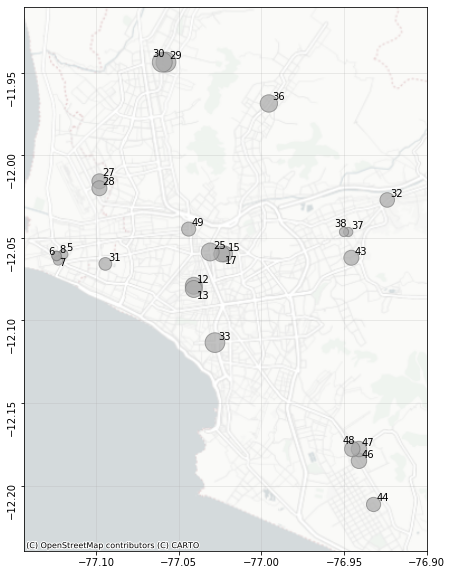

In [11]:
# buildings
bldg_id = hosp_data_mod['ID'].values
lon = hosp_data_mod['lon'].values
lat = hosp_data_mod['lat'].values
size = [mu[h]*svr[h]*15 for h in bldg_id]

geo_dict = {'ID': bldg_id, 'size': size, 'geometry': [Point(xy) for xy in zip(lon,lat)]}
geo_df = gpd.GeoDataFrame(geo_dict, crs = 'epsg:4326')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # setup the plot
geo_df.plot(ax = ax, markersize = geo_df['size'], color = 'darkgrey', edgecolors = 'grey', alpha = 0.7)

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.ID):
    if label == 48 or label == 38 or label == 30 or label == 6:
        ax.annotate(label, xy=(x, y), xytext=(-10, 5), textcoords="offset points")
    elif label == 27:
        ax.annotate(label, xy=(x, y), xytext=(3, 5), textcoords="offset points")
    elif label == 13 or label == 7 or label == 17:
        ax.annotate(label, xy=(x, y), xytext=(3, -10), textcoords="offset points")
    else:
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels, zoom = 11)
ax.grid(alpha = 0.3)
plt.yticks(rotation = 90)
plt.show()

## Capacities of All Simulation

In [12]:
capacities = np.zeros(10000)
num_H = np.zeros(10000)
for i in range(10000):
    # get damaged buildings
    H = data.loc[data['Sim{}'.format(i)] != 0, 'ID'].values
    H0 = data.loc[data['Sim{}'.format(i)] == 0, 'ID'].values
    num_H[i] = len(H)
    
    # calculate capacity
    capacities[i] = sum([val for key,val in svr.items() if key in H0])*list(mu.values())[0]

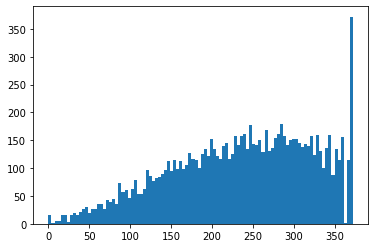

In [13]:
plt.hist(capacities, bins = 100)
plt.show()

In [14]:
# get 10th percentile
p10 = np.percentile(capacities, 10, interpolation = 'nearest')
idx_10 = abs(capacities-p10).argmin()

In [15]:
np.where(np.abs(capacities-p10) == 0)

(array([ 299,  426, 4160, 6665, 8129, 9813]),)

In [16]:
capacities[299]

114.6

# Read from Results

In [17]:
def get_results(folder):
    files = [join(folder,f) for f in listdir(folder) if isfile(join(folder,f)) and f.startswith('result')]
    results_all = []
    for filename in files:
        with open(filename) as f:
            results_all.append(json.load(f))

    greedy_area = np.zeros(len(results_all))
    greedy_order = []
    results_cost = []
    times = []
    
    for i in range(len(results_all)):
        greedy_area[i] = results_all[i]['greedy_area']
        greedy_order.append(results_all[i]['greedy_order'])
        if len(results_all[i]['results_cost_wo_tmp']) == 0:
            results_cost.append(results_all[i]['results_cost'])
        else:
            results_cost.append(results_all[i]['results_cost_wo_tmp'])
        times.append(results_all[i]['times'])
    
    return greedy_area, greedy_order, results_cost, times

In [14]:
greedy_area_list, greedy_order_list, results_cost_list, times_list = get_results('../lima_simulation')

In [15]:
# calculate number of times in top 3
top3 = {h: {'top3': 0, 'damaged': 0} for h in H_all}
for i in range(len(greedy_order_list)):
    greedy_order = greedy_order_list[i]
    if len(greedy_order) > 6: # take only simulations with more than 7 damaged buildings
        for j in range(len(greedy_order)): 
            if j < 3:# take only top 3
                top3[greedy_order[j]]['top3'] += 1
            top3[greedy_order[j]]['damaged'] += 1

In [16]:
top3

{5: {'top3': 63, 'damaged': 2148},
 6: {'top3': 204, 'damaged': 4477},
 7: {'top3': 73, 'damaged': 2133},
 8: {'top3': 78, 'damaged': 2176},
 12: {'top3': 1607, 'damaged': 2960},
 13: {'top3': 1629, 'damaged': 2947},
 15: {'top3': 1985, 'damaged': 4876},
 17: {'top3': 851, 'damaged': 1715},
 25: {'top3': 1463, 'damaged': 3244},
 27: {'top3': 608, 'damaged': 5505},
 28: {'top3': 734, 'damaged': 5515},
 29: {'top3': 1213, 'damaged': 1605},
 30: {'top3': 2014, 'damaged': 4350},
 31: {'top3': 148, 'damaged': 1751},
 32: {'top3': 630, 'damaged': 3500},
 33: {'top3': 1138, 'damaged': 2490},
 36: {'top3': 1309, 'damaged': 1875},
 37: {'top3': 115, 'damaged': 5403},
 38: {'top3': 98, 'damaged': 5717},
 43: {'top3': 495, 'damaged': 1845},
 44: {'top3': 588, 'damaged': 4343},
 46: {'top3': 856, 'damaged': 3169},
 47: {'top3': 847, 'damaged': 3162},
 48: {'top3': 707, 'damaged': 2610},
 49: {'top3': 494, 'damaged': 5222}}

In [17]:
#probability top 3 given damage
prob_top3 = {h:top3[h]['top3']/top3[h]['damaged'] for h in top3.keys()} 

In [18]:
prob_top3

{5: 0.029329608938547486,
 6: 0.0455662273844092,
 7: 0.03422409751523676,
 8: 0.035845588235294115,
 12: 0.5429054054054054,
 13: 0.5527655242619613,
 15: 0.40709598031173094,
 17: 0.49620991253644314,
 25: 0.45098643649815046,
 27: 0.11044504995458673,
 28: 0.13309156844968267,
 29: 0.7557632398753894,
 30: 0.4629885057471264,
 31: 0.0845231296402056,
 32: 0.18,
 33: 0.4570281124497992,
 36: 0.6981333333333334,
 37: 0.021284471589857485,
 38: 0.017141857617631626,
 43: 0.2682926829268293,
 44: 0.13539028321436794,
 46: 0.27011675607447144,
 47: 0.2678684376976597,
 48: 0.27088122605363985,
 49: 0.09459977020298736}

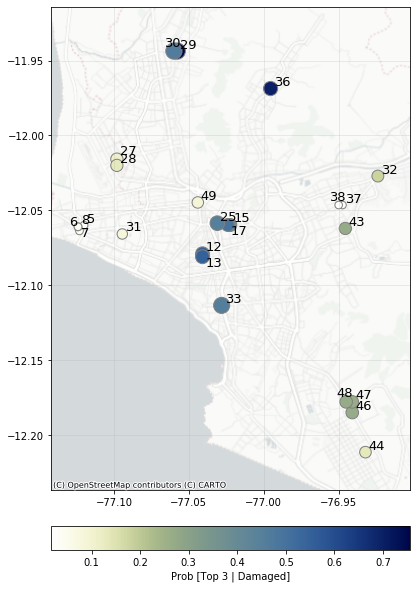

In [19]:
bldg_id = prob_top3.keys()
lon = [hosp_data_mod.loc[hosp_data_mod['ID'] == b, 'lon'].values[0] for b in bldg_id]
lat = [hosp_data_mod.loc[hosp_data_mod['ID'] == b, 'lat'].values[0] for b in bldg_id]
size = [mu[h]*svr[h]*10 for h in bldg_id]

geo_dict = {'ID': bldg_id, 'prob': [prob_top3[b] for b in bldg_id], 'size': size,
           'geometry': [Point(xy) for xy in zip(lon,lat)]}

geo_df = gpd.GeoDataFrame(geo_dict, crs = 'epsg:4326')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))  # setup the plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.5)

geo_df.plot(ax = ax, column = 'prob', markersize = geo_df['size'], edgecolors = 'grey', cmap = cm.davos_r, 
            legend = True, legend_kwds = {'label': 'Prob [Top 3 | Damaged]', 'orientation': 'horizontal'}, cax = cax)

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.ID):
    if label == 48 or label == 38 or label == 30 or label == 6:
        ax.annotate(label, xy=(x, y), xytext=(-10, 5), textcoords="offset points", size = 13)
    elif label == 27:
        ax.annotate(label, xy=(x, y), xytext=(3, 5), textcoords="offset points", size = 13)
    elif label == 13 or label == 7 or label == 17:
        ax.annotate(label, xy=(x, y), xytext=(3, -10), textcoords="offset points", size = 13)
    else:
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", size = 13)

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels, zoom = 11)
ax.grid(alpha = 0.3)

plt.savefig('figures/prob_map.png', dpi = 600, bbox_inches='tight')
plt.show()

# 10th percentile (scenario 6665)

In [38]:
i = 6665 #299, 426, 4160, 6665, 8129, 9813 ## 4160 is good
prio = [1,2]
avg_speed = 30

# get damaged buildings
H = data.loc[data['Sim{}'.format(i)] != 0, 'ID'].values
H0 = data.loc[data['Sim{}'.format(i)] == 0, 'ID'].values
print('Number of damaged buildings {} out of {}'.format(len(H), len(H_all)))

# get construction time
hazus = {1: 10, 2: 45, 3: 180, 4: 360}
T = {}
for h in H_all:
    damage_level = data.loc[data['ID'] == h, 'Sim{}'.format(i)].values[0]
    if h in H:
        T[h] = hazus[damage_level] # using median values
    else:
        T[h] = 0

Number of damaged buildings 16 out of 25


In [39]:
greedy_order, results = greedy(H,H0, T, f, svr, mu, prio, avg_speed, travel_time = travel_time)

Intializing Arrays... Calculating Initial Allocation
Not enough capacity!
total capacity 114.6
total demand 295.0



ValueError: Not enough capacity!

In [40]:
total_capacity = 114.6
total_arrival_rate = 295.0
# total_capacity = 34.2
# total_arrival_rate = 295.0
all_facilities = np.concatenate([H,H0])
tmp_id, f_tmp, svr_tmp, mu_tmp, cons_time_tmp, travel_time_tmp = add_temp_facility(total_capacity, total_arrival_rate, all_facilities, mu, f, svr, T, travel_time = travel_time)

In [41]:
greedy_order, results = greedy_tmp(H,H0, tmp_id, cons_time_tmp, f_tmp, svr_tmp, mu_tmp, 
                                   prio, avg_speed, travel_time = travel_time_tmp)

Intializing Arrays... Calculating Initial Allocation
Calculating Calculation Ordering...
chosen facility 36
chosen facility 47
chosen facility 28
chosen facility 49
chosen facility 6
chosen facility 25
chosen facility 13
chosen facility 27
chosen facility 30
chosen facility 33
chosen facility 48
chosen facility 46
chosen facility 12
chosen facility 15
chosen facility 37
chosen facility 38
Construction Order: [36, 47, 28, 49, 6, 25, 13, 27, 30, 33, 48, 46, 12, 15, 37, 38]


In [42]:
# Fastest Construction Time
cons_order = get_cons_order(T, H)
print('Construction Order:', cons_order)
cons_results = manual_order_tmp(cons_order, H,H0, tmp_id, f_tmp, svr_tmp, mu_tmp, 
                                prio, avg_speed, travel_time = travel_time_tmp)

Construction Order: [6, 28, 36, 47, 49, 13, 25, 27, 12, 15, 30, 33, 37, 38, 46, 48]


In [43]:
# Most Capacity
capacity_order = get_capacity_order(svr, H)
print('Capacity Order:', capacity_order)
capacity_results = manual_order_tmp(capacity_order, H,H0, tmp_id, f_tmp, svr_tmp, mu_tmp, 
                                    prio, avg_speed, travel_time = travel_time_tmp)

Capacity Order: [30, 33, 25, 36, 12, 13, 15, 46, 47, 48, 27, 28, 49, 6, 37, 38]


priority 1
Greedy Order 5784.0
Damage Order 6312.0
Capacity Order 179424.0

priority 2
Greedy Order 1227144.0
Damage Order 1439304.0
Capacity Order 4055532.0



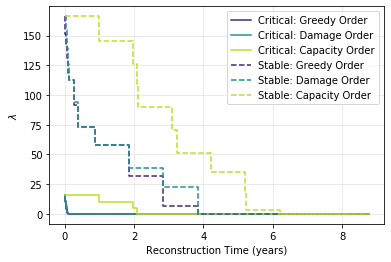

In [44]:
# Disaggregated by priority
orders_list = [greedy_order, cons_order, capacity_order]
results_list = [results, cons_results, capacity_results]
labels = ['Greedy Order', 'Damage Order', 'Capacity Order']
patienttype = ['Critical', 'Stable']
linestyles = ['-', '--']

cmap = mpl.cm.get_cmap('viridis')
colors = [cmap(0.1), cmap(0.5), cmap(0.9)]
plt.figure()

for k in range(2):
    print('priority {}'.format(k+1))
    for i in range(len(orders_list)):
        untreated = count_untreated_prio(prio[k], H,tmp_id, results_list[i])
        x_time = create_times(orders_list[i], T)     
        plt.plot(x_time/365, untreated, drawstyle = 'steps-post', linestyle = linestyles[k], 
                 label = '{}: {}'.format(patienttype[k], labels[i]), color = colors[i])
        print(labels[i], np.trapz(untreated, x_time)*24)
    print()
    
plt.xlabel('Reconstruction Time (years)')
plt.ylabel('$\lambda$')
# plt.yscale('symlog')
# plt.ylim([0, 200])
plt.grid(alpha = 0.3)
plt.legend()

plt.savefig('figures/untreated_disagg.png', dpi = 600)

plt.show()

priority 0
Greedy Order 0.574568263244964
Damage Order 0.6996249862362247
Capacity Order 461.4067026682428

priority 1
Greedy Order 270.3189416280041
Damage Order 362.1349507446844
Capacity Order 1276.8177976969087



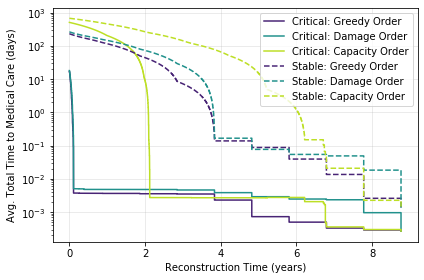

In [45]:
# Plot total time disagg by priority
orders_list = [greedy_order, cons_order, capacity_order]
results_list = [results, cons_results, capacity_results]
labels = ['Greedy Order', 'Damage Order', 'Capacity Order']
patienttype = ['Critical', 'Stable']
linestyles = ['-', '--']

cmap = mpl.cm.get_cmap('viridis')
colors = [cmap(0.1), cmap(0.5), cmap(0.9)]

for k in range(2):
    print('priority {}'.format(k))
    
    for i in range(len(orders_list)): 
        wait_home = wait_at_home(results_list[i], T, tmp_id, prio[k], travel_time = travel_time)
        plt.plot(np.arange(len(wait_home))/365, wait_home, drawstyle = 'steps-post', 
                 label = '{}: {}'.format(patienttype[k], labels[i]), color = colors[i], linestyle = linestyles[k])
        print(labels[i], np.trapz(wait_home, np.arange(len(wait_home))/365))
    
    print()
    plt.xlabel('Reconstruction Time (years)')
    plt.ylabel('Avg. Total Time to Medical Care (days)')
    plt.grid('on', alpha = 0.3)
    plt.legend()
    plt.yscale('log')
#     plt.ylim([0.0003, 1000])
#     plt.title('Priority {}'.format(k))

plt.tight_layout()
plt.savefig('figures/wait_all.png', dpi = 600)
plt.show()

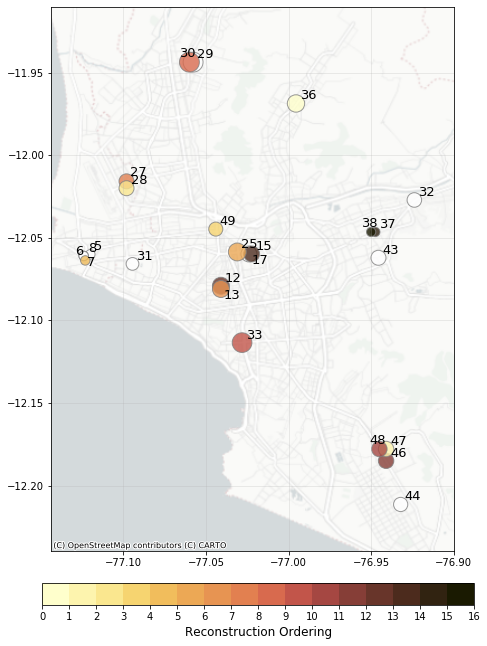

In [28]:
# Greedy order
map_ordering(hosp_data_mod, greedy_order, H, H0, mu, svr, 'figures/map_greedy.png')

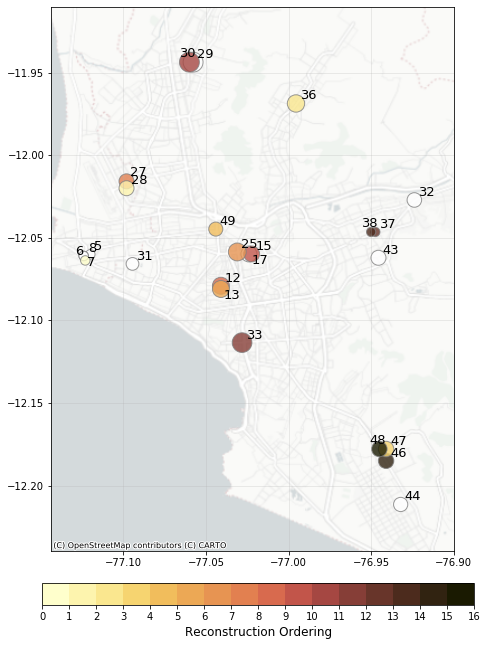

In [29]:
# Construction order
map_ordering(hosp_data_mod, cons_order, H, H0, mu, svr, 'figures/map_damage.png')

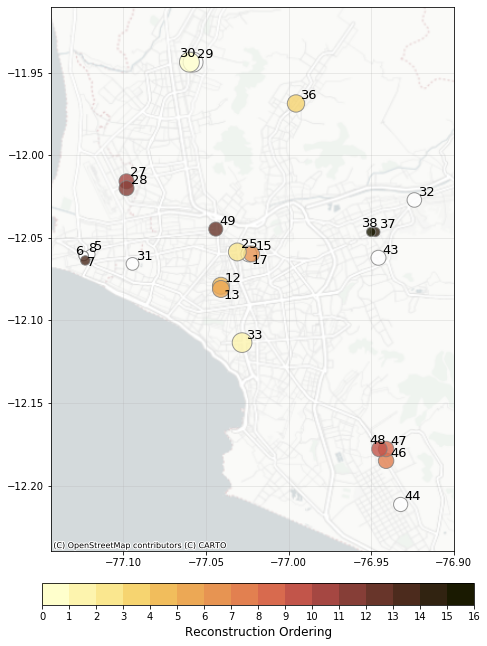

In [30]:
# Capacity order
map_ordering(hosp_data_mod, capacity_order, H, H0, mu, svr, 'figures/map_capacity.png')

## Multiple construction crews

In [46]:
num_crews = 2

1
Greedy Order 0.4003358069812553
Damage Order 0.41724960788590126
Capacity Order 155.2299639129566
2
Greedy Order 96.84207126488306
Damage Order 124.2763123260429
Capacity Order 347.3949919795184


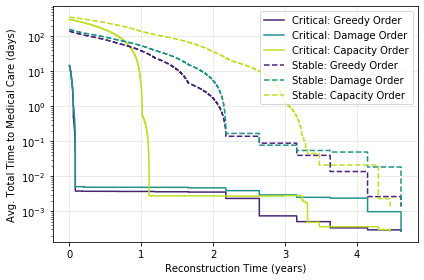

In [47]:
# Plot total time disagg by priority
orders_list = [greedy_order, cons_order, capacity_order]
results_list = [results, cons_results, capacity_results]
labels = ['Greedy Order', 'Damage Order', 'Capacity Order']
patienttype = ['Critical', 'Stable']
linestyles = ['-', '--']

cmap = mpl.cm.get_cmap('viridis')
colors = [cmap(0.1), cmap(0.5), cmap(0.9)]

for k in range(2):
    print(k+1)
    
    for i in range(len(orders_list)): 
        wait_home = wait_at_home(results_list[i], T, tmp_id, prio[k], travel_time = travel_time, num_crews = num_crews)
        plt.plot(np.arange(len(wait_home))/365, wait_home, drawstyle = 'steps-post', 
                 label = '{}: {}'.format(patienttype[k], labels[i]), color = colors[i], linestyle = linestyles[k])
        print(labels[i], np.trapz(wait_home, np.arange(len(wait_home))/365))
    
    plt.xlabel('Reconstruction Time (years)')
    plt.ylabel('Avg. Total Time to Medical Care (days)')
    plt.grid('on', alpha = 0.3)
    plt.legend()
    plt.yscale('log')
#     plt.ylim([0.0003, 1000])
#     plt.title('Priority {}'.format(k))

plt.tight_layout()
plt.savefig('figures/wait_all_2crews.png', dpi = 600)
plt.show()

# 2nd scenario

In [33]:
i = 9810 
prio = [1,2]
avg_speed = 30

# get damaged buildings
H = data.loc[data['Sim{}'.format(i)] != 0, 'ID'].values
H0 = data.loc[data['Sim{}'.format(i)] == 0, 'ID'].values
print('Number of damaged buildings {} out of {}'.format(len(H), len(H_all)))

# get construction time
hazus = {1: 10, 2: 45, 3: 180, 4: 360}
T = {}
for h in H_all:
    damage_level = data.loc[data['ID'] == h, 'Sim{}'.format(i)].values[0]
    if h in H:
        T[h] = hazus[damage_level] # using median values
    else:
        T[h] = 0

Number of damaged buildings 16 out of 25


In [34]:
greedy_order, results = greedy(H,H0, T, f, svr, mu, prio, avg_speed, travel_time = travel_time)

Intializing Arrays... Calculating Initial Allocation
Not enough capacity!
total capacity 138.29999999999998
total demand 294.99999999999994



ValueError: Not enough capacity!

In [35]:
total_capacity = 138.3
total_arrival_rate = 295.0
# total_capacity = 34.2
# total_arrival_rate = 295.0
all_facilities = np.concatenate([H,H0])
tmp_id, f_tmp, svr_tmp, mu_tmp, cons_time_tmp, travel_time_tmp = add_temp_facility(total_capacity, total_arrival_rate, all_facilities, mu, f, svr, T, travel_time = travel_time)

In [36]:
greedy_order, results = greedy_tmp(H,H0, tmp_id, cons_time_tmp, f_tmp, svr_tmp, mu_tmp, 
                                   prio, avg_speed, travel_time = travel_time_tmp)

Intializing Arrays... Calculating Initial Allocation
Calculating Calculation Ordering...
chosen facility 29
chosen facility 25
chosen facility 36
chosen facility 15
chosen facility 48
chosen facility 27
chosen facility 31
chosen facility 8
chosen facility 6
chosen facility 37
chosen facility 43
chosen facility 49
chosen facility 30
chosen facility 28
chosen facility 38
chosen facility 32
Construction Order: [29, 25, 36, 15, 48, 27, 31, 8, 6, 37, 43, 49, 30, 28, 38, 32]


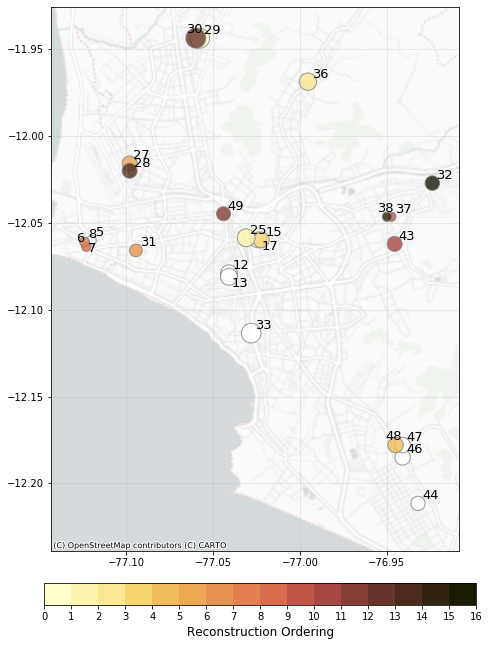

In [37]:
# Greedy order
map_ordering(hosp_data_mod, greedy_order, H, H0, mu, svr, 'figures/map_greedy_16.png')